In [48]:
# reload
%load_ext autoreload
%autoreload 2

In [89]:
import numpy as np

import matplotlib.pyplot as plt

import sys
sys.path.append('../')
import funPlots as fplot

import seaborn as sns
from scipy.stats import entropy

def load_matplotlib_local_fonts():
    from matplotlib import font_manager
    
    font_path = '/home/barzon/Avenir.ttc'
    
    font_manager.fontManager.addfont(font_path)
    prop = font_manager.FontProperties(fname=font_path)

    #  Set it as default matplotlib font
    plt.rcParams.update({
        'font.sans-serif': prop.get_name(),
    })
    
load_matplotlib_local_fonts()

fplot.master_format(ncols = 2, nrows = 1)

In [50]:
from utils.simulation import *
from utils.mutual import (compute_mutual_information_from_trajectories, mutual_information_slowjumps_dh_D, MC_underhood)
from utils.analytical import *

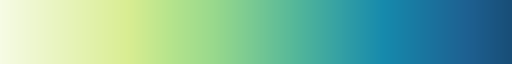

In [51]:
import matplotlib.patheffects as pe
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

colors = ["#F6FBE4", "#ECF6C9", "#E3F2AE", "#d9ed92", "#b5e48c", "#99d98c",
          "#76c893", "#52b69a", "#34a0a4", "#168aad", "#1a759f", "#1e6091", "#184e77"]
nodes = np.linspace(0, 1, len(colors))
cmap_SR = LinearSegmentedColormap.from_list("cmap_SR", list(zip(nodes, colors)))
cmap_SR.set_bad(color='w')
cmap_SR

In [52]:
data_folder = 'data/'

my_cmap_continuous = sns.color_palette('mako_r', as_cmap=True)

colors = ("#76c893", "#184e77")
labels = ('$E$', '$I$')

## Input projection

In [53]:
kmin, kmax = 0.01, 5
wmin, wmax = 1, 10
sigmah = 1

nk, nw = int(1e3), int(5e2)

ws = np.linspace(wmin, wmax, nw)
Ks = np.zeros((nw, nk))
Ws = np.zeros((nw, nk))

for idx_w, w in enumerate(ws):
    kcrit = 1 - 1/w
    if w <=1:
        k_list = np.linspace(kmin, kmax, nk)
    else:
        k_list = np.geomspace(1e-12, kcrit/2, 500) + kcrit
        k_list = np.concatenate([np.linspace(kcrit*(1 + 1/2), kmax, nk - 500), k_list])
    Ks[idx_w] = np.sort(k_list)
    Ws[idx_w] = w

unstable = np.where(1 + Ws*(Ks-1)<=0)

Istat = np.zeros(Ks.shape)
SDer = np.zeros(Ks.shape)

for idx_w, w in enumerate(ws):
    for idx_k, k in enumerate(Ks[idx_w]):
        if 1 + w*(k-1)<=0:
            Istat[idx_w, idx_k] = np.nan
            SDer[idx_w, idx_k] = np.nan
        else:
            Istat[idx_w, idx_k] = mutual_stat_input_global(w, k, sigmah)
            SDer[idx_w, idx_k] = mutual_second_der_global(w, k, sigmah)

Istat /= np.log(2)
SDer /= np.log(2)

/tmp/ipykernel_135205/2207054908.py:6: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  axs["cp_chi"].pcolormesh(Ks, Ws, SDer, cmap=cmap_SR, rasterized = True)
/tmp/ipykernel_135205/2207054908.py:29: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  axs["cp_ist"].pcolormesh(Ks, Ws, np.log10(Istat), cmap=cmap_SR, rasterized = True)


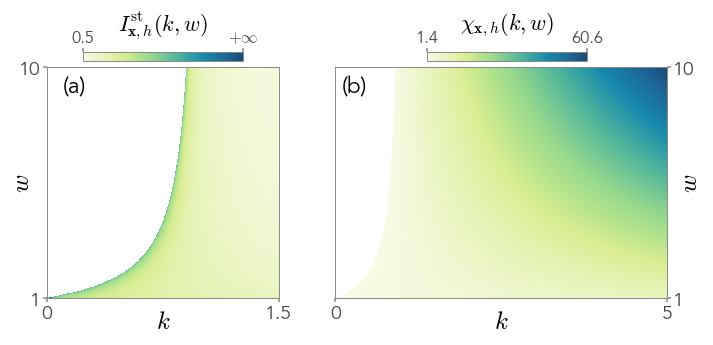

In [110]:
fig, axs = plt.subplot_mosaic([["cp_ist","cp_chi"]],
                               figsize = (8, 3),
                               gridspec_kw = {'width_ratios': [.7, 1]})

plt.subplots_adjust(wspace=0.2, hspace=0.3)
axs["cp_chi"].pcolormesh(Ks, Ws, SDer, cmap=cmap_SR, rasterized = True)
axs["cp_chi"].set_xlabel('$k$', labelpad = -10, fontsize = 18)
axs["cp_chi"].set_ylabel('$w$', labelpad = -12, fontsize = 18)
#axs["cp_chi"].set_aspect(0.5)
axs["cp_chi"].set_yticks([1, 10])
axs["cp_chi"].set_xticks([0, 5])
axs["cp_chi"].tick_params(axis='both', which='major', labelsize=14)

axs["cp_chi"].yaxis.set_label_position("right")
axs["cp_chi"].yaxis.tick_right()

chi_max = np.nanmax(SDer)
chi_min = np.nanmin(SDer)

cax = fig.add_axes([0.6, 0.9, 0.2, 0.03])
cbar = plt.colorbar(axs["cp_chi"].collections[0], cax=cax, orientation='horizontal')
cax.xaxis.set_ticks_position('top')
cax.xaxis.set_label_position('top')
cbar.set_ticks([chi_min, chi_max])
cbar.set_ticklabels([f'{chi_min:.1f}', f'{chi_max:.1f}'], fontsize = 12)
cbar.set_label(r'$\chi_{\mathbf{x},h}(k, w)$', labelpad = 0, fontsize = 16)


axs["cp_ist"].pcolormesh(Ks, Ws, np.log10(Istat), cmap=cmap_SR, rasterized = True)
axs["cp_ist"].set_xlabel('$k$', labelpad = -10, fontsize = 18)
axs["cp_ist"].set_ylabel('$w$', labelpad = -12, fontsize = 18)
#axs["cp_ist"].set_aspect(0.3)
axs["cp_ist"].set_xlim(0.0,1.5)
axs["cp_ist"].set_xticks([0, 1.5])
axs["cp_ist"].set_xticklabels(["0", "1.5"])
axs["cp_ist"].set_yticks([1, 10])
axs["cp_ist"].tick_params(axis='both', which='major', labelsize=14)

ist_max = np.nanmax(np.log10(Istat))
ist_min = np.nanmin(np.log10(Istat))

cax = fig.add_axes([0.17, 0.9, 0.2, 0.03])
cbar = plt.colorbar(axs["cp_ist"].collections[0], cax=cax, orientation='horizontal')
cax.xaxis.set_ticks_position('top')
cax.xaxis.set_label_position('top')
cbar.set_ticks([ist_min, ist_max])
cbar.set_ticklabels([f'{10**ist_min:.1f}', '$+\infty$'], fontsize = 12)
cbar.set_label(r'$I_{\mathbf{x},h}^\mathrm{st} (k, w)$', labelpad = 0, fontsize = 16)

axs["cp_ist"].text(0.1,9,'(a)', fontsize=16)
axs["cp_chi"].text(0.1,9,'(b)', fontsize=16)

plt.savefig('figures/Figure_suppl_input_projection.png', dpi = 300, bbox_inches = 'tight')

plt.show()

# Nonlinear - delta_h = 0.15

In [177]:
### Info input
M = 3
tau_h = 100
wup = 1 / tau_h
wdown = 1 / tau_h
delta_h = 1.
D = 0.05
hs = np.arange(M) * delta_h
hs = np.stack([hs, np.zeros(M)])

W = create_transition_matrix_star_graph(M, wup, wdown)

p_stat = np.array([wdown] + [wup] * (M-1))
p_stat = p_stat / p_stat.sum()

In [178]:
ks = np.load(data_folder+f'k_list_nonlinear.npy')
ks_large = np.load(data_folder+f'k_list_nonlinear_large.npy')
n_runs = 10
tau_hs = [1000, 250] #[1000, 500, 250]
ws = [2, 4, 6] #[1, 2, 4, 6]

res_linear = np.zeros((len(tau_hs), len(ws), ks.size, n_runs))
res_nonlinear = np.zeros((len(tau_hs), len(ws), ks.size, n_runs))

for ih, tau_h in enumerate(tau_hs):
    for iw, w in enumerate(ws):
        tmp_res_linear = np.load(f'data/mutual_linear_w_{w}_tau_{tau_h}_dh_{delta_h}_k_{ks[0]}_{ks[-1]}_{ks.size}.npy')
        tmp_res_nonlinear = np.load(f'data/mutual_nonlinear_w_{w}_tau_{tau_h}_dh_{delta_h}_k_{ks[0]}_{ks[-1]}_{ks.size}.npy')
        
        res_linear[ih,iw] = tmp_res_linear
        res_nonlinear[ih,iw] = tmp_res_nonlinear
        
mi_imp_samp = np.zeros((len(ws), ks_large.size))

for i, w in enumerate(ws):
    mi_importance_sampling = np.load(data_folder+f'mutual_importance_sampling_fixedw{w}_deltah_{delta_h}_D_{D}.npy')
    mi_imp_samp[i] = mi_importance_sampling

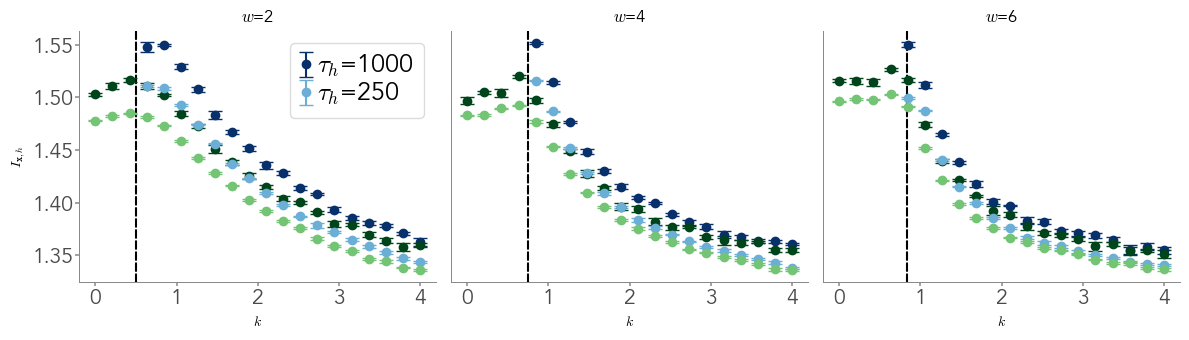

In [179]:
figsize=(12,3.5)
cmaps_lin = plt.get_cmap('Blues_r',len(tau_hs)+1)
cmaps_nonlin = plt.get_cmap('Greens_r',len(tau_hs)+1)

plt.figure(figsize=figsize)

for i, w in enumerate(ws):
    mi_importance_sampling = mi_imp_samp[i]

    #plt.figure(figsize=(6,3))
    plt.subplot(1,len(ws),i+1)
    
    for j, tau_h in enumerate(tau_hs):
        plt.errorbar(ks, res_linear[j,i].mean(axis=1), res_linear[j,i].std(axis=1) / np.sqrt(res_linear[j,i].shape[1]), label=r'$\tau_h$='+str(tau_h), fmt='o', capsize=5, c=cmaps_lin(j))
        plt.errorbar(ks, res_nonlinear[j,i].mean(axis=1), res_nonlinear[j,i].std(axis=1) / np.sqrt(res_linear[j,i].shape[1]), fmt='o', capsize=5, c=cmaps_nonlin(j))
    
    #plt.plot(ks_large, mi_importance_sampling / np.log(2), '-', label=r'$\tau_{input}\gg \tau$', c='k', zorder=0)

    plt.axvline(1-1/w, c='k', ls='--', zorder=-1)
    #plt.axhline(entropy(p_stat) / np.log(2), c='gray', ls='--', lw=3, label=r'$H_{jumps}$', zorder=1)

    plt.xlabel('$k$')
    plt.title(f'$w$={w}')

    if i==0:
        plt.legend()
        plt.ylabel('$I_{\mathbf{x},h}$')
    else:
        plt.yticks([])
        
plt.tight_layout()
sns.despine()
plt.show()        

# Nonlinear - delta_h = 0.15

In [180]:
### Info input
M = 3
tau_h = 100
wup = 1 / tau_h
wdown = 1 / tau_h
delta_h = 0.15
D = 0.001
hs = np.arange(M) * delta_h
hs = np.stack([hs, np.zeros(M)])

W = create_transition_matrix_star_graph(M, wup, wdown)

p_stat = np.array([wdown] + [wup] * (M-1))
p_stat = p_stat / p_stat.sum()

In [181]:
ks = np.load(data_folder+f'k_list_nonlinear.npy')
ks_large = np.load(data_folder+f'k_list_nonlinear_large.npy')
n_runs = 10
tau_hs = [1000, 250] #[1000, 500, 250]
ws = [2, 4, 6] #[1, 2, 4, 6]

res_linear = np.zeros((len(tau_hs), len(ws), ks.size, n_runs))
res_nonlinear = np.zeros((len(tau_hs), len(ws), ks.size, n_runs))

for ih, tau_h in enumerate(tau_hs):
    for iw, w in enumerate(ws):
        tmp_res_linear = np.load(f'data/mutual_linear_w_{w}_tau_{tau_h}_dh_{delta_h}_k_{ks[0]}_{ks[-1]}_{ks.size}.npy')
        tmp_res_nonlinear = np.load(f'data/mutual_nonlinear_w_{w}_tau_{tau_h}_dh_{delta_h}_k_{ks[0]}_{ks[-1]}_{ks.size}.npy')
        
        res_linear[ih,iw] = tmp_res_linear
        res_nonlinear[ih,iw] = tmp_res_nonlinear
        
mi_imp_samp = np.zeros((len(ws), ks_large.size))

for i, w in enumerate(ws):
    mi_importance_sampling = np.load(data_folder+f'mutual_importance_sampling_fixedw{w}_deltah_{delta_h}_D_{D}.npy')
    mi_imp_samp[i] = mi_importance_sampling

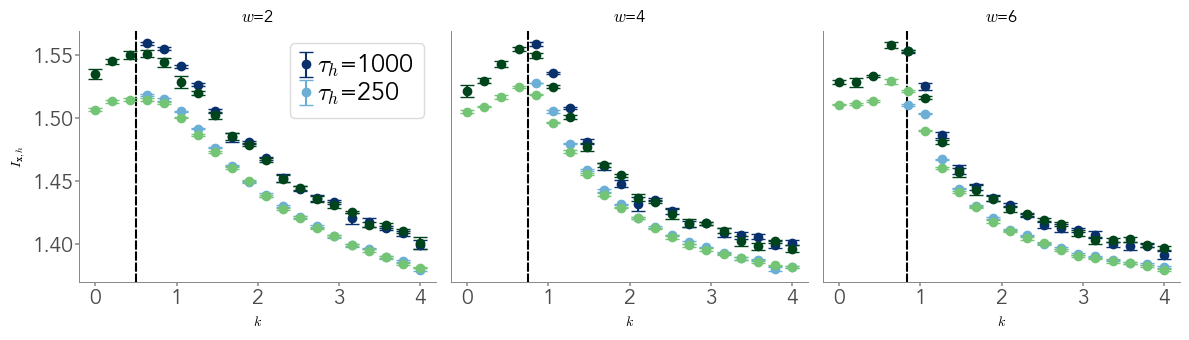

In [182]:
figsize=(12,3.5)
cmaps_lin = plt.get_cmap('Blues_r',len(tau_hs)+1)
cmaps_nonlin = plt.get_cmap('Greens_r',len(tau_hs)+1)

plt.figure(figsize=figsize)

for i, w in enumerate(ws):
    mi_importance_sampling = mi_imp_samp[i]

    #plt.figure(figsize=(6,3))
    plt.subplot(1,len(ws),i+1)
    
    for j, tau_h in enumerate(tau_hs):
        plt.errorbar(ks, res_linear[j,i].mean(axis=1), res_linear[j,i].std(axis=1) / np.sqrt(res_linear[j,i].shape[1]), label=r'$\tau_h$='+str(tau_h), fmt='o', capsize=5, c=cmaps_lin(j))
        plt.errorbar(ks, res_nonlinear[j,i].mean(axis=1), res_nonlinear[j,i].std(axis=1) / np.sqrt(res_linear[j,i].shape[1]), fmt='o', capsize=5, c=cmaps_nonlin(j))
    
    #plt.plot(ks_large, mi_importance_sampling / np.log(2), '-', label=r'$\tau_{input}\gg \tau$', c='k', zorder=0)

    plt.axvline(1-1/w, c='k', ls='--', zorder=-1)
    #plt.axhline(entropy(p_stat) / np.log(2), c='gray', ls='--', lw=3, label=r'$H_{jumps}$', zorder=1)

    plt.xlabel('$k$')
    plt.title(f'$w$={w}')

    if i==0:
        plt.legend()
        plt.ylabel('$I_{\mathbf{x},h}$')
    else:
        plt.yticks([])
        
plt.tight_layout()
sns.despine()
plt.show()        

In [ ]:
# merge
# add two fake rows for adding title delta_h=

## Effect of noise and input strength

In [131]:
### Info input
M = 3
tau_h = 100
wup = 1 / tau_h
wdown = 2 / tau_h
delta_h = 2.5
hs = np.arange(M) * delta_h
hs = np.stack([hs, np.zeros(M)])

W = create_transition_matrix_star_graph(M, wup, wdown)

p_stat = np.array([wdown] + [wup] * (M-1))
p_stat = p_stat / p_stat.sum()

In [132]:
### Define fix params
w = 2
k = 1.1
r = 1

### Define grid params
dhmin, dhmax = 0.001, 3
Dmin, Dmax = 0.001, 1

nh, nD = int(2e2), int(2e2)

dh_list, D_list = np.linspace(dhmin, dhmax, nh), np.linspace(Dmin, Dmax, nD)

print(dh_list.size * D_list.size)

Hs, Ds = np.meshgrid(dh_list, D_list)

40000


In [46]:
### Compute mutual
#mutuals = mutual_information_slowjumps_dh_D(w, k, r, D_list, dh_list, p_stat, nsamples = int(1e4))
#np.save(data_folder+'mutual_importance_sampling_dh_D.npy', mutuals)

In [133]:
mutuals = np.load(data_folder+'mutual_importance_sampling_dh_D.npy')

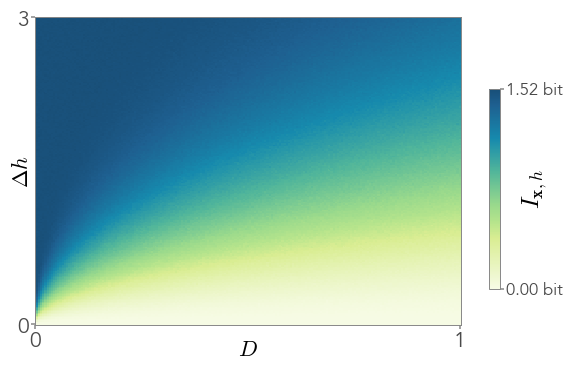

In [174]:
fig, axs = plt.subplot_mosaic([["CP"]],
                               figsize = (5.5, 4),
                               gridspec_kw = {'height_ratios': [1]})
plt.subplots_adjust(hspace=0.3, wspace=0.)
axs["CP"].pcolor(Ds, Hs, mutuals.T/np.log(2), cmap=cmap_SR, rasterized = True, shading = 'auto')
#axs["CP"].plot(1-1/w_list, w_list, ls = '--', color='#2b2d42', lw=2.5, label = "$k_c = 1 - 1/w$",
#               path_effects=[pe.Stroke(linewidth=4.5, foreground='lightgray'), pe.Normal()],
#               dashes=[2.3, 2])

axs["CP"].set_xlim(Dmin,None)

axs["CP"].set_xlabel('$D$', labelpad = -10, fontsize=16)
axs["CP"].set_ylabel('$\Delta h$', labelpad = -12, fontsize=16)
axs["CP"].set_xticks([0, D_list.max()])
axs["CP"].set_yticks([0, dh_list.max()])

#axs["CP"].legend(fontsize = 14, bbox_to_anchor=(1.05, 1.3), loc='upper left')

cax = fig.add_axes([.95, 0.2, 0.02, 0.5])
cbar = plt.colorbar(axs["CP"].collections[0], cax=cax, orientation='vertical')
cbar.set_label(label = r'$I_{\mathbf{x},h}$', fontsize=18, labelpad=-30)
cax.xaxis.set_ticks_position('top')
cax.xaxis.set_label_position('top')

min_mutual = 0#np.nanmin(mutuals)/np.log(2)
max_mutual = np.nanmax(mutuals)/np.log(2)

cbar.set_ticks([min_mutual , max_mutual])
cbar.set_ticklabels([f'{min_mutual:.2f} bit', f'{max_mutual:.2f} bit'], fontsize = 12)

plt.savefig('figures/Figure_suppl_noise_input_strength.png', dpi = 300, bbox_inches = 'tight')

plt.show()